## Stock Clusters

Identifying stock clusters helps discover similar companies which can be useful for comparable analysis or pairs trading strategy. We can find similar clusters by estimating the inverse covariance (precision) matrix which can be used to construct a graph network of dependencies. The difference between opening and closing daily price was used to compute empirical covariance used to fit graph lasso algorithm to estimate sparse precision matrix. Affinity propagation was used to compute the stock clusters and a linear embedding was used to display high dimensional data in 2D.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import linalg

from datetime import datetime
import pytz

from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphLassoCV, ledoit_wolf
from sklearn.preprocessing import StandardScaler
from sklearn import cluster, manifold

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas_datareader.data as web

np.random.seed(0)

Let's choose a universe of stocks:

In [2]:
#generate data (actual)
STOCKS = {
    'SPY': 'S&P500',
    'LQD': 'Bond_Corp',
    'TIP': 'Bond_Treas',
    'GLD': 'Gold',
    'MSFT': 'Microsoft',
    'XOM':  'Exxon',
    'AMZN': 'Amazon',
    'BAC':  'BofA',
    'NVS':  'Novartis'}
      
symbols, names = np.array(list(STOCKS.items())).T

In [7]:
from pandas_datareader.google.daily import GoogleDailyReader

@property
def url(self):
    return 'http://finance.google.com/finance/historical'

GoogleDailyReader.url = url

# get data

import pandas_datareader as pdr
from datetime import datetime

start = datetime(2010,1,1)
end = datetime(2014,1,1)
ret = pdr.get_data_google(['AAPL'], start, end)

In [13]:
# ret["Open"]

In [11]:
#load data
#year, month, day, hour, minute, second, microsecond

start = datetime(2015, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2017, 1, 1, 0, 0, 0, 0, pytz.utc)    

qopen, qclose = [], []
data_close, data_open = pd.DataFrame(), pd.DataFrame()    
for ticker in symbols:
#     price = web.DataReader(ticker, 'google', start, end)
    price = pdr.get_data_google([ticker], start, end)
    qopen.append(price['Open'])
    qclose.append(price['Close'])

data_open = pd.concat(qopen, axis=1)
data_open.columns = symbols
data_close = pd.concat(qclose, axis=1)
data_close.columns = symbols

We'll take the difference in closing and opening daily prices as empirical covariance:

In [14]:
#per day variation in price for each symbol
variation = data_close - data_open
variation = variation.dropna()    
variation.head()

,MSFT,SPY,LQD,AMZN,TIP,GLD,BAC,XOM,NVS
Date,,,,,,,,,
2015-01-02,0.10,-0.95,0.23,-4.06,0.51,1.59,-0.09,0.58,-0.58
2015-01-05,-0.05,-2.45,0.13,-4.82,0.06,1.02,-0.40,-1.81,-0.98
2015-01-06,-0.73,-2.27,0.16,-6.95,-0.21,0.90,-0.56,-0.43,-0.71
2015-01-07,0.25,0.89,0.33,0.92,0.33,-0.04,-0.20,0.07,0.72
2015-01-08,0.84,1.89,-0.07,0.14,0.01,-0.51,0.13,0.98,1.10


We'll standardize the data to use correlation rather than covariance:

In [15]:
X = variation.values
X /= X.std(axis=0)

Estimate inverse covariance using graph lasso algorithm:

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function grid_scores is deprecated; Attribute grid_scores was deprecated in version 0.19 and will be removed in 0.21. Use ``grid_scores_`` instead
  warnings.warn(msg, category=DeprecationWarning)


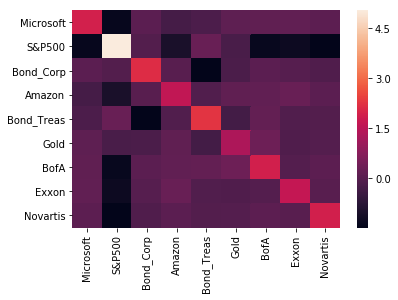

In [16]:
#estimate inverse covariance    
graph = GraphLassoCV()
graph.fit(X)
    
gl_cov = graph.covariance_
gl_prec = graph.precision_
gl_alphas =graph.cv_alphas_
gl_scores = np.mean(graph.grid_scores, axis=1)

plt.figure()        
sns.heatmap(gl_prec, xticklabels=names, yticklabels=names)
plt.show()

Edges in the above precision matrix that are greater than a threshold correspond to connected components from which we can compute stock clusters.

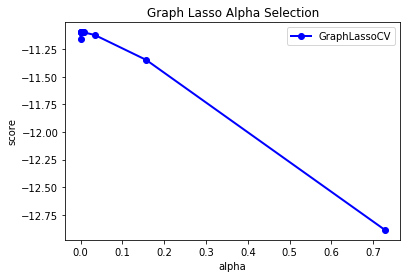

In [17]:
plt.figure()    
plt.plot(gl_alphas, gl_scores, marker='o', color='b', lw=2.0, label='GraphLassoCV')
plt.title("Graph Lasso Alpha Selection")
plt.xlabel("alpha")
plt.ylabel("score")
plt.legend()
plt.show()

The above plot shows the cross-validation of $l1$ penalty parameter $\alpha$. Let's do affinity based clustering next:

In [18]:
#cluster using affinity propagation
_, labels = cluster.affinity_propagation(gl_cov)
num_labels = np.max(labels)
    
for i in range(num_labels+1):
    print("Cluster %i: %s" %((i+1), ', '.join(names[labels==i])))

Cluster 1: Microsoft, S&P500, Amazon, BofA, Exxon, Novartis
Cluster 2: Bond_Corp, Bond_Treas, Gold


Compute a 2D embedding for visualization:

In [19]:
#find a low dim embedding for visualization
node_model = manifold.LocallyLinearEmbedding(n_components=2, n_neighbors=6, eigen_solver='dense')
embedding = node_model.fit_transform(X.T).T

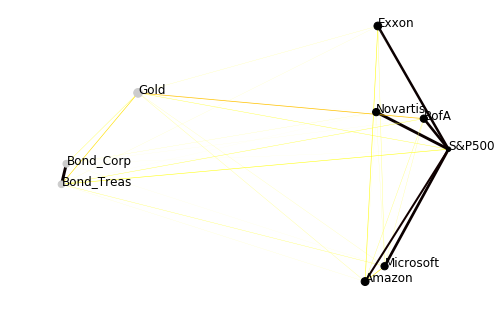

In [20]:
#generate plots
plt.figure()
plt.clf()
ax = plt.axes([0.,0.,1.,1.])
plt.axis('off')
    
partial_corr = gl_prec
d = 1 / np.sqrt(np.diag(partial_corr))    
non_zero = (np.abs(np.triu(partial_corr, k=1)) > 0.02)  #connectivity matrix
    
#plot the nodes
plt.scatter(embedding[0], embedding[1], s = 100*d**2, c = labels, cmap = plt.cm.spectral)
    
#plot the edges
start_idx, end_idx = np.where(non_zero)
segments = [[embedding[:,start], embedding[:,stop]] for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_corr[non_zero])
lc = LineCollection(segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0,0.7*values.max()))
lc.set_array(values)
lc.set_linewidths(2*values)
ax.add_collection(lc)
    
#plot the labels
for index, (name, label, (x,y)) in enumerate(zip(names, labels, embedding.T)):
    plt.text(x,y,name,size=12)
    
plt.show()